# Toxic Comments Classification

# Author : Amirreza Eskandarani

# Importing necessary libraries

In [58]:
! pip install transformers

In [59]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.offline as pyo
import plotly.graph_objects as go
import re
from wordcloud import WordCloud, STOPWORDS
import nltk

import torch
from torch.utils.data import DataLoader, TensorDataset
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# import os
# import zipfile
import warnings
warnings.filterwarnings('ignore')

In [60]:
!pip install nltk
nltk.download('stopwords')
from nltk.corpus import stopwords


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [61]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Load the Dataset

In [63]:
train = pd.read_csv("/content/drive/MyDrive/toxic comments classification/data/train.csv")
train.sample(5)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
560,0176cc057449e5d1,"""\n""""IMDb content is user-submitted and often ...",0,0,0,0,0,0
19557,33a7e4122b3da607,"""\n\nComposers project review\nI've reviewed t...",0,0,0,0,0,0
159105,f8978a7f6de123d3,"""\n\n , the Consensus is not """"removing the ed...",0,0,0,0,0,0
59539,9f76989ce05c1a60,THE SAS artilce was completely innacurate and ...,0,0,0,0,0,0
131782,c123b71e899fe446,"""\n\nFair use rationale for Image:Leonidas_01....",0,0,0,0,0,0


In [64]:
test = pd.read_csv("/content/drive/MyDrive/toxic comments classification/data/test.csv")
test.sample(3)

,id,comment_text
142376,ee055dbca1b8880e,== Headline text == \n\n == Headline text == \...
97631,a2e9de5c5122d587,"""There is a MAJOR difference between speed and..."
16423,1b9e3187dacf2e47,""" \n\n I have never attempted to attribute mot..."


In [65]:
submission = pd.read_csv("/content/drive/MyDrive/toxic comments classification/data/sample_submission.csv")
submission.sample(3)

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
147489,f688aeee4559feeb,0.5,0.5,0.5,0.5,0.5,0.5
16660,1c05fa88b2555d64,0.5,0.5,0.5,0.5,0.5,0.5
149367,f9b233edaf4534f5,0.5,0.5,0.5,0.5,0.5,0.5


In [66]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


# Preprocessing

In [67]:
train.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [68]:
def clean_text(text):


    # Remove HTML tags
    text = re.sub(r'<[^>]+>', '', text)

    # remove non English words
    text = re.sub(r'[^\x00-\x7f]',r'', text)

    # Remove web links
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)

    # remove tags and mentions
    text = re.sub(r'@\S*','',text)
    text = re.sub(r'#\S*','',text)

    # Remove special characters, punctuation marks, and numbers
    text = re.sub(r'[^a-zA-Z\s]', ' ', text)

    # remove letters that occur more than 2 times
    text = re.sub(r'(\w)\1{2,}', r'\1',text)

    # Insert spaces between certain patterns (e.g., "ie", "eg")
    text = re.sub(r'(\s)([iI][eE]|[eE][gG])(\s)', r' \2 ', text)

    # Remove extra white spaces
    text = " ".join(text.split())

    # Removing stopwords
    stop_words = set(stopwords.words('english'))
    tokens = text.split()
    tokens = [token for token in tokens if token not in stop_words]

    # Removing empty tokens
    tokens = [token for token in tokens if token]

    for token in tokens:
        token = str(token)

    # Joining the tokens back into a single string
    preprocessed_text = ' '.join(tokens)

    return preprocessed_text.lower()

# Example usage with the provided text
texts = [
    "\nMore\nI can't make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of 'types of accidents'  -I think the references may need tidying so that they are all in the exact same format ie date format etc I can do that later on, if no-one else does first - if you have any preferences for formatting style on references or want to do it yourself please let me know.\n\nThere appears to be a backlog on articles for review so I guess there may be a delay until a reviewer turns up. It's listed in the relevant form eg Wikipedia:Good_article_nominations#Transport"
]

cleaned_texts = [clean_text(text) for text in texts]
print(cleaned_texts)

['more i make real suggestions improvement i wondered section statistics later subsection types accidents i think references may need tidying exact format ie date format etc i later one else first preferences formatting style references want please let know there appears backlog articles review i guess may delay reviewer turns it listed relevant form eg wikipedia good article nominations']


In [71]:
train['Cleaned_Comments'] = train['comment_text'].apply(clean_text)
train['Cleaned_Comments'].head()

0    explanation why edits made username hardcore m...
1    d aww he matches background colour i seemingly...
2    hey man i really trying edit war it guy consta...
3    more i make real suggestions improvement i won...
4                you sir hero any chance remember page
Name: Cleaned_Comments, dtype: object

## Data Visualization to Understand Class Distribution

In [70]:
target_labels= [col for col in train.columns if train[col].dtypes == 'int64']
target_labels

['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

In [72]:
comments=train['Cleaned_Comments'].to_list()
comments[:5]

['explanation why edits made username hardcore metallica fan reverted they vandalisms closure gas i voted new york dolls fac and please remove template talk page since i retired',
 'd aww he matches background colour i seemingly stuck thanks talk january utc',
 'hey man i really trying edit war it guy constantly removing relevant information talking edits instead talk page he seems care formatting actual info',
 'more i make real suggestions improvement i wondered section statistics later subsection types accidents i think references may need tidying exact format ie date format etc i later one else first preferences formatting style references want please let know there appears backlog articles review i guess may delay reviewer turns it listed relevant form eg wikipedia good article nominations',
 'you sir hero any chance remember page']

In [73]:
# Function to generate word cloud
def generate_wordcloud(text,Title):
    wordcloud = WordCloud(width=800, height=400,stopwords=set(STOPWORDS), background_color='black').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(Title)
    plt.show()

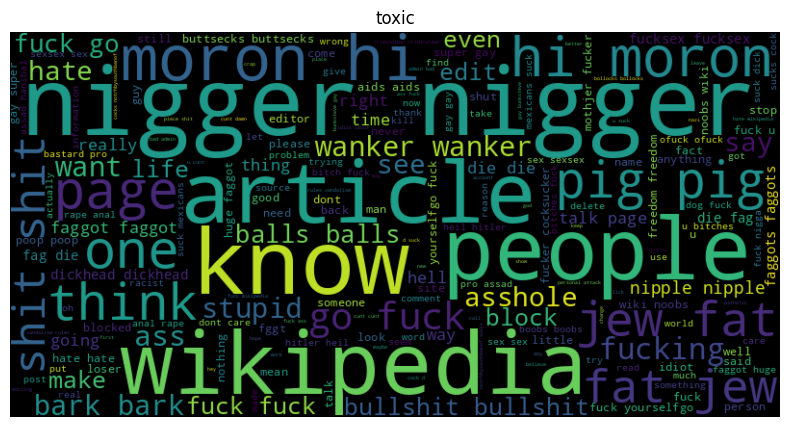

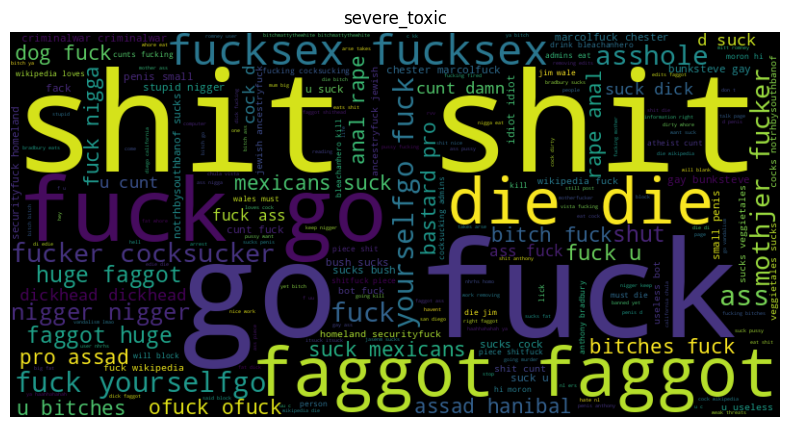

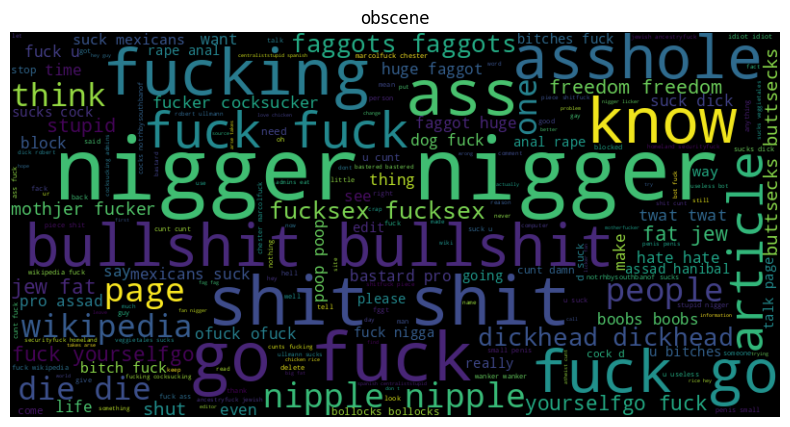

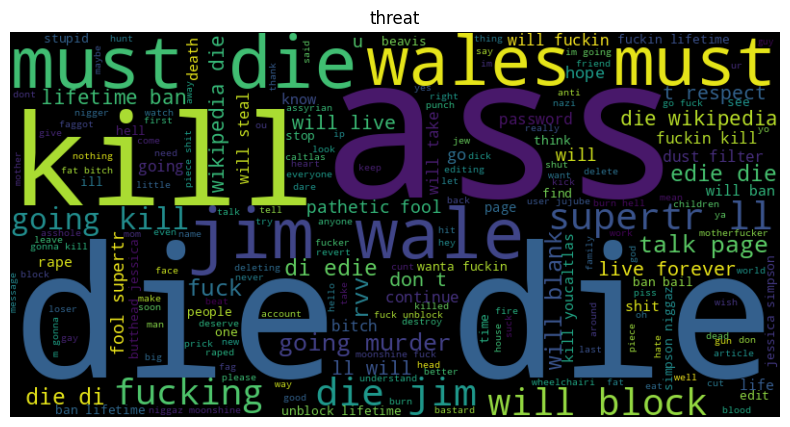

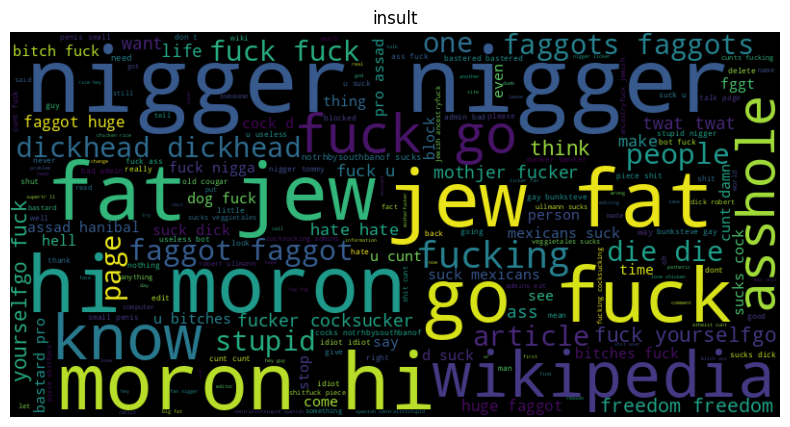

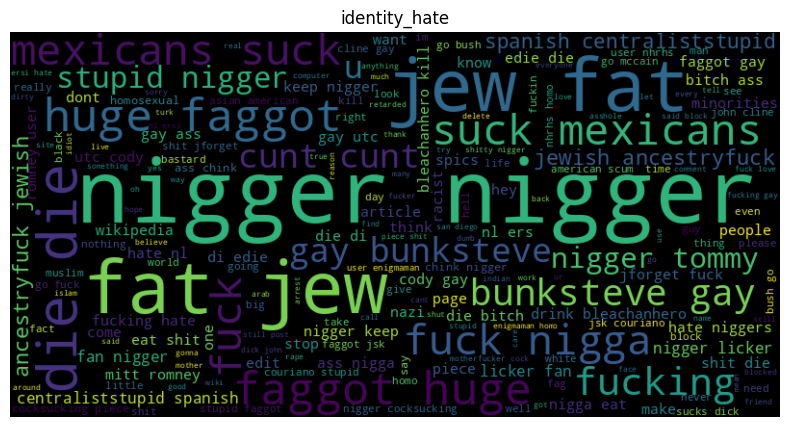

In [74]:
# Plot word clouds for each target label
for label in target_labels:
    text = ' '.join(train[train[label] == 1]['Cleaned_Comments'].values)
    generate_wordcloud(text,Title=label)

In [75]:
train[target_labels].sum()

toxic            15294
severe_toxic      1595
obscene           8449
threat             478
insult            7877
identity_hate     1405
dtype: int64

In [76]:
# Calculate the value counts for each target label
value_counts = train[target_labels].sum()

# Add the count for the "neither" category (where all target labels are 0)
value_counts['Good Comments'] = len(train) - value_counts.sum()

fig =px.bar(x= value_counts.index,
            y= value_counts.values,
            color=value_counts.index,
            color_discrete_sequence =  px.colors.qualitative.Dark24_r,
            title='<b>Counts of Target Labels')

fig.update_layout(title='Counts of Target Labels',
                  xaxis_title='Toxicity Labels',
                  yaxis_title='Counts',
                  template='plotly_dark')

# Show the bar chart
fig.show()
pyo.plot(fig, filename = 'Counts of Target Labels.html', auto_open = True)

'Counts of Target Labels.html'

# Split the dataset into Train, Test and Validation

In [77]:
# Split data into training, testing sets & validation sets
Train_texts, Test_texts, Train_labels, Test_labels = train_test_split(
    comments, train[target_labels].values, test_size=0.25, random_state=23)

#validation set
test_texts, val_texts, test_labels, val_labels = train_test_split(
    Test_texts, Test_labels, test_size=0.5, random_state=23)

print('Training Dataset -->',len(Train_texts), Train_labels.shape)
print('Testing Dataset -->',len(test_texts), test_labels.shape)
print('Training Dataset -->',len(val_texts), val_labels.shape)

Training Dataset --> 119678 (119678, 6)
Testing Dataset --> 19946 (19946, 6)
Training Dataset --> 19947 (19947, 6)


# Fine-tune BERT Model for Multilabel Classification

#### Tokenization & encoding using BertTokenizer

In [78]:
def tokenize_and_encode(tokenizer, comments, labels, max_length=128):
    # Initialize empty lists to store tokenized inputs and attention masks
    input_ids = []
    attention_masks = []

    # Iterate through each comment in the 'comments' list
    for comment in comments:
        # Tokenize and encode the comment using the BERT tokenizer
        encoded_dict = tokenizer.encode_plus(
            comment,
            add_special_tokens=True,
            max_length=max_length,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        # Append the tokenized input and attention mask to their respective lists
        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])

    # Convert the lists of tokenized inputs and attention masks to PyTorch tensors
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)

    # Convert the labels to a PyTorch tensor with the data type float32
    labels = torch.tensor(labels, dtype=torch.float32)

    # Return the tokenized inputs, attention masks, and labels as PyTorch tensors
    return input_ids, attention_masks, labels

In [79]:
# Token Initialization
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# Model Initialization
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=6)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [80]:
# Move model to GPU if available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

model =model.to(device)

cuda


In [81]:
# Tokenize and Encode the comments and labels for the training set
input_ids, attention_masks, labels = tokenize_and_encode(
    tokenizer,
    Train_texts,
    Train_labels
)

# Step 4: Tokenize and Encode the comments and labels for the test set
test_input_ids, test_attention_masks, test_labels = tokenize_and_encode(
    tokenizer,
    test_texts,
    test_labels
)

# Tokenize and Encode the comments and labels for the validation set
val_input_ids, val_attention_masks, val_labels = tokenize_and_encode(
    tokenizer,
    val_texts,
    val_labels
)

print('Training Comments :',len(Train_texts))
print('Input Ids         :',input_ids.shape)
print('Attention Mask    :',attention_masks.shape)
print('Labels            :',labels.shape)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Training Comments : 119678
Input Ids         : torch.Size([119678, 128])
Attention Mask    : torch.Size([119678, 128])
Labels            : torch.Size([119678, 6])


In [82]:
k = 523
print('Training Comments -->>',Train_texts[k])
print('\nInput Ids -->>\n',input_ids[k])
print('\nDecoded Ids -->>\n',tokenizer.decode(input_ids[k]))
print('\nAttention Mask -->>\n',attention_masks[k])
print('\nLabels -->>',labels[k])

Training Comments -->> first i made changes i stepped rv war could least read made changes inteligent comentary changes discussion ceha

Input Ids -->>
 tensor([  101,  2034,  1045,  2081,  3431,  1045,  3706, 27634,  2162,  2071,
         2560,  3191,  2081,  3431, 13420, 29206,  2102,  2272, 12380,  2854,
         3431,  6594,  8292,  3270,   102,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,    

## Creating DataLoaders for training dataset

In [83]:
# Creating DataLoader for the balanced dataset
batch_size = 32
train_dataset = TensorDataset(input_ids, attention_masks, labels)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

#test
test_dataset = TensorDataset(test_input_ids, test_attention_masks, test_labels)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

#val
val_dataset = TensorDataset(val_input_ids, val_attention_masks, val_labels)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [84]:
print('Batch Size :',train_loader.batch_size)
Batch =next(iter(train_loader))
print('Each Input ids shape :',Batch[0].shape)
print('Input ids :\n',Batch[0][0])
print('Corresponding Decoded text:\n',tokenizer.decode(Batch[0][0]))
print('Corresponding Attention Mask :\n',Batch[1][0])
print('Corresponding Label:',Batch[2][0])

Batch Size : 32
Each Input ids shape : torch.Size([32, 128])
Input ids :
 tensor([  101,  2129,  3087,  4339,  3969,  8568, 26201,  2553,  7543,  2720,
         3969,  6691,  3423,  2381,  2590,  3772,  2002, 26201,  8419,  2919,
         3319,  3772,  2414,  2754,   102,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     

### Initialising optimizer
Initializes the optimizer for training the model

Adam with Weight Decay (AdamW) is a variant of the Adam optimizer that incorporates weight decay (L2 regularization) during the parameter updates. It is an extension of the original Adam optimizer and addresses some of its limitations when using weight decay as a regularization technique.

In [85]:
# Optimizer setup
optimizer = AdamW(model.parameters(), lr=0.00002)

# Model training

In [86]:
def train_model(model, train_loader, val_loader, optimizer, device, num_epochs):
    # Loop through the specified number of epochs
    for epoch in range(num_epochs):
        # Set the model to training mode
        model.train()
        # Initialize total loss for the current epoch
        total_loss = 0

        # Loop through the batches in the training data
        for batch in train_loader:
            input_ids, attention_mask, labels = [t.to(device) for t in batch]

            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            total_loss += loss.item()

            loss.backward()
            optimizer.step()

        model.eval()  # Set the model to evaluation mode
        val_loss = 0

        # Disable gradient computation during validation
        with torch.no_grad():
            for batch in val_loader:
                input_ids, attention_mask, labels = [t.to(device) for t in batch]

                outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
                loss = outputs.loss
                val_loss += loss.item()

        # Print the average loss for the current epoch
        print(f'Epoch {epoch+1}, Training Loss: {total_loss/len(train_loader)}, Validation Loss: {val_loss/len(val_loader)}')

# Assuming you have 'train_loader' and 'val_loader' defined elsewhere
# Call the function to train the model
train_model(model, train_loader, val_loader, optimizer, device, num_epochs=3)


Epoch 1, Training Loss: 0.05440916378607595, Validation Loss: 0.042629523007631995
Epoch 2, Training Loss: 0.03631315776518917, Validation Loss: 0.04027754544408825
Epoch 3, Training Loss: 0.028958529132944538, Validation Loss: 0.04448950647332449


# Model Evaluation

In [87]:
# Evaluate the Model
def evaluate_model(model, test_loader, device):
    model.eval()  # Set the model to evaluation mode

    true_labels = []
    predicted_probs = []

    with torch.no_grad():
        for batch in test_loader:
            input_ids, attention_mask, labels = [t.to(device) for t in batch]

            # Get model's predictions
            outputs = model(input_ids, attention_mask=attention_mask)
            predicted_probs_batch = torch.sigmoid(outputs.logits)  # Use sigmoid for multilabel classification
            predicted_probs.append(predicted_probs_batch.cpu().numpy())

            true_labels_batch = labels.cpu().numpy()
            true_labels.append(true_labels_batch)

    # Combine predictions and labels for evaluation
    true_labels = np.concatenate(true_labels, axis=0)
    predicted_probs = np.concatenate(predicted_probs, axis=0)
    predicted_labels = (predicted_probs > 0.5).astype(int)  # Apply threshold for binary classification

    # Calculate evaluation metrics
    accuracy = accuracy_score(true_labels, predicted_labels)
    precision = precision_score(true_labels, predicted_labels, average='micro')
    recall = recall_score(true_labels, predicted_labels, average='micro')
    f1score = f1_score(true_labels, predicted_labels, average='micro')


    # Print the evaluation metrics
    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 score: {f1score:.4f}')


# Call the function to evaluate the model on the test data
evaluate_model(model, test_loader, device)

Accuracy: 0.9203
Precision: 0.7436
Recall: 0.8290
F1 score: 0.7840


## Save the model

In [107]:
# Save the tokenizer and model in the same directory
output_dir = "/content/drive/MyDrive/project-toxic/toxic-model-v2"
model.save_pretrained(output_dir)  # Save model's state dictionary and configuration
tokenizer.save_pretrained(output_dir)  # Save tokenizer's configuration and vocabulary

('/content/drive/MyDrive/project-toxic/toxic-model-v2/tokenizer_config.json',
 '/content/drive/MyDrive/project-toxic/toxic-model-v2/special_tokens_map.json',
 '/content/drive/MyDrive/project-toxic/toxic-model-v2/vocab.txt',
 '/content/drive/MyDrive/project-toxic/toxic-model-v2/added_tokens.json')

## Load the model

In [108]:
# Load the tokenizer and model from the saved directory
model_name = "/content/drive/MyDrive/project-toxic/toxic-model-v2"
Bert_Tokenizer = BertTokenizer.from_pretrained(model_name)
Bert_Model = BertForSequenceClassification.from_pretrained(model_name).to(device)

# Prediction for user input

In [109]:
def predict_user_input(input_text, model=Bert_Model, tokenizer=Bert_Tokenizer,device=device):
    user_input = [input_text]

    user_encodings = tokenizer(user_input, truncation=True, padding=True, return_tensors="pt")

    user_dataset = TensorDataset(user_encodings['input_ids'], user_encodings['attention_mask'])

    user_loader = DataLoader(user_dataset, batch_size=1, shuffle=False)

    model.eval()
    with torch.no_grad():
        for batch in user_loader:
            input_ids, attention_mask = [t.to(device) for t in batch]
            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            predictions = torch.sigmoid(logits)

    predicted_labels = (predictions.cpu().numpy() > 0.5).astype(int)
    return predicted_labels[0].tolist()

In [110]:
text = 'Are you insane!'
predict_user_input(input_text=text)

[1, 0, 0, 0, 1, 0]

In [111]:
predict_user_input(input_text='How are you?')

[0, 0, 0, 0, 0, 0]

In [112]:
input_text = 'You are insane'
predict_user_input(input_text)

[1, 0, 0, 0, 1, 0]

In [113]:
text = "Such a Idiot person"
predict_user_input(model=Bert_Model,
                   tokenizer=Bert_Tokenizer,
                   input_text=text,
                   device=device)

[1, 0, 0, 0, 1, 0]

In [114]:
text = "I'll kill you"
predict_user_input(model=Bert_Model,
                   tokenizer=Bert_Tokenizer,
                   input_text=text,
                   device=device)

[1, 0, 0, 1, 0, 0]

In [115]:
text = "I'll kill you"
predict_user_input(model=Bert_Model,
                   tokenizer=Bert_Tokenizer,
                   input_text=text,
                   device=device)

[1, 0, 0, 1, 0, 0]

In [116]:
text = "I'll kill you"
predict_user_input(model=Bert_Model,
                   tokenizer=Bert_Tokenizer,
                   input_text=text,
                   device=device)


[1, 0, 0, 1, 0, 0]

In [117]:
def predict_label(predicted_label):
    labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
    labels_pridicted = ""
    for i in range(len(predicted_label)):
        if predicted_label[i] == 1:
            labels_pridicted += labels[i] + " "


    print(f'Prdicted label(s) for your comment is: {labels_pridicted}.')



In [118]:
text = "I'll kill you"
predicted_labels = predict_user_input(model=Bert_Model,
                   tokenizer=Bert_Tokenizer,
                   input_text=text,
                   device=device)
predict_label(predicted_labels)

Prdicted label(s) for your comment is: toxic threat .


# Submission

In [119]:
test['Cleaned_Comments'] = test['comment_text'].apply(clean_text)

In [120]:
test_labels = pd.read_csv("/content/drive/MyDrive/toxic comments classification/data/test_labels.csv")
test_labels.head(3)

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,-1,-1,-1,-1,-1,-1
1,0000247867823ef7,-1,-1,-1,-1,-1,-1
2,00013b17ad220c46,-1,-1,-1,-1,-1,-1


In [121]:
%%time
test_labels[target_labels]=test['Cleaned_Comments'].apply(predict_user_input).tolist()

# Save the
test_labels.to_csv('/content/drive/MyDrive/project-toxic/final_submission-v2.csv', index=False, header=True)
df = pd.read_csv('/content/drive/MyDrive/project-toxic/final_submission-v2.csv')
df.head()


CPU times: user 43min, sys: 7.07 s, total: 43min 7s
Wall time: 44min 15s


,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,1,1,1,0,1,1
1,0000247867823ef7,0,0,0,0,0,0
2,00013b17ad220c46,0,0,0,0,0,0
3,00017563c3f7919a,0,0,0,0,0,0
4,00017695ad8997eb,0,0,0,0,0,0
